# Double and Pseudo Double source plane cosmology forecast

Here we run the forecast for the w0waCDM cosmology and save the posteriors.

In [1]:
%load_ext autoreload
%autoreload 2

# --- Standard Library ---
import copy
import pickle
import os
from copy import deepcopy
from itertools import combinations
from multiprocessing import Pool, cpu_count

# --- Scientific / Numerical ---
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import norm

# --- Visualization ---
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import display, Markdown, Math
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm
import corner
from matplotlib.gridspec import GridSpec
from scipy.stats import gaussian_kde

# --- Astropy ---
from astropy import constants as const
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits
from astropy.table import Table
from astropy.units import Quantity

# --- SLSim ---
import slsim.Deflectors as deflectors
import slsim.Pipelines as pipelines
import slsim.Sources as sources
from slsim.Lenses.lens import Lens
from slsim.Lenses.lens_pop import LensPop
from slsim.LOS.los_pop import LOSPop
from slsim.Plots.lens_plots import LensingPlots

# --- Lenstronomy / HierArc ---
import emcee
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from lenstronomy.LensModel.lens_model import LensModel
from hierarc.Sampling.ParamManager.cosmo_param import CosmoParam
from hierarc.Sampling.mcmc_sampling import MCMCSampler

# --- ChainConsumer ---
from chainconsumer import Chain, ChainConfig, ChainConsumer, PlotConfig, Truth
from chainconsumer.plotting import plot_contour

# --- Local Utilities ---
from pdspl_analysis_utils import normalize_data, get_pairs_table_PDSPL, kdtree_matching_n_dim, draw_lens_from_given_zs
from pdspl_analysis_utils import OmegaMPrior

# --- Matplotlib Style ---
plt.style.use("../paper_style.mplstyle")

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-068 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-072
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf
/Users/paras/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
POSTERIOR_DIR = "../data/posteriors/"
FIGURES_DIR = "../figures/forecasts/"

In [3]:
# --- Cosmology used in SLSim and to use for forecasting ---
cosmology = "w0waCDM"  # Flat wCDM cosmology
# other options are: "FLCDM FwCDM", "w0waCDM", "oLCDM"
om_true = 0.3
w0_true = -1
wa_true = 0
h0_true = 70
kwargs_cosmo_true = {"h0": h0_true, "om": om_true, "w0": w0_true, "wa": wa_true}  # cosmological model of the forecast

cosmo_param = CosmoParam(cosmology=cosmology)
cosmo_true = cosmo_param.cosmo(kwargs_cosmo_true)

In [4]:
# load the pdspl_samples object with pickle
# with open('../data/samples/pdspl_samples_with_pairs.pkl', 'rb') as f:
#     pdspl_samples = pickle.load(f)

## Forecast settings

Here we describe the redshift distribution, precision on Einstein radii ratios of an anticipated sample


In [5]:
# define hierarchical model
kwargs_model = {
    "lambda_mst_sampling": True,
    "lambda_mst_distribution": "NONE",  # TODO: switch to GAUSSIAN
    "gamma_pl_global_sampling": True,
    "gamma_pl_global_dist": "NONE",  # TODO: switch to GAUSSIAN
    "log_scatter": False,
}

gamma_pl_mean = 2.078
gamma_pl_sigma = 0.16 # from Auger et al. 2010 for SLACS lenses

lambda_mst_mean = 1.0
lambda_mst_sigma = 0.05

In [6]:
# ########################################################
# ### Define forecast samples dictionary
# ########################################################

# num_PDSPL_samples_forecast = 500  # number of PDSPL systems to use in forecast

# forecast_samples = {
#     "DSPL": {
#         "num_systems": 87,  # number of DSPL systems
#         "rel_scatter_in_beta_E": 0.01,  # relative scatter in beta_E from DSPL analysis
#         "num_systems_forecast": 87, # only use these many systems in the forecast with appropriate downsampling factor
#         "kwargs_likelihood_list": None,
#         "name": "DSPL (87 lenses)",
#         "color": "blue",
#     },
#     # "lsst_single_visit": {
#     #     "num_systems": ,
#     #     "rel_scatter_in_beta_E": ,
#     #     "num_systems_forecast": num_PDSPL_samples_forecast,
#     #     "kwargs_likelihood_list": None,
#     #     "name": "PDSPL (LSST SINGLE)",
#     #     "color": "tab:orange",
#     # },
#     "lsst_y10": {
#         "num_systems": len(pdspl_samples['lsst_y10']['pairs_analysis']['pairs_table']),
#         "num_systems_forecast": num_PDSPL_samples_forecast,
#         "kwargs_likelihood_list": None,
#         "name": "PDSPL (LSST Y10)",
#         "color": "green",
#     },
#     "lsst_4most_spec-z": {
#         "num_systems": len(pdspl_samples['lsst_4most_spec-z']['pairs_analysis']['pairs_table']),
#         "num_systems_forecast": num_PDSPL_samples_forecast,
#         "kwargs_likelihood_list": None,
#         "name": "PDSPL (4MOST $z^{\\rm spec}$)",
#         "color": "red",
#     },
#     "lsst_4most_spec-z_sigma_v": {
#         "num_systems": len(pdspl_samples['lsst_4most_spec-z_sigma_v']['pairs_analysis']['pairs_table']),
#         "num_systems_forecast": num_PDSPL_samples_forecast,
#         "kwargs_likelihood_list": None,
#         "name": "PDSPL (4MOST $z^{\\rm spec}$ + $\\sigma_{v, D}$)",
#         "color": "purple",
#     },
# }

# # add down sampling factor
# for key in forecast_samples.keys():
#     n_total = forecast_samples[key]['num_systems']
#     n_forecast = forecast_samples[key]['num_systems_forecast']
#     downsample_factor = n_total / n_forecast
#     forecast_samples[key]['down_sampling_factor'] = downsample_factor

# ########################################################
# ### Print forecast samples summary
# ########################################################
# print("\nForecast Samples Summary:")
# print('-'*80)
# for key in forecast_samples.keys():
#     s = forecast_samples[key]
#     print(f"{s['name']:<46} # systems: {s['num_systems']:<10} | down-sampling factor: {s['down_sampling_factor']:.2f}")
# print('-'*80)

## Generate DSPL kwargs_likelihoods

In [7]:
# load the Sharma++23 DSPL sample of 87 DSPLs
# dspl_sample_table = Table.read("../extra/sharma++23_lsst_dspl.txt", format='ascii')

# dspl_sample_table

In [8]:
# ########################################################
# ### Settings for population of DSPL
# ########################################################

# kwargs_dspl_list = []

# for i in range(forecast_samples['DSPL']['num_systems_forecast']):
#     z_lens = np.random.uniform(low=0.1, high=1)
#     z1 = 0
#     while z1 < z_lens:
#         z1 = np.random.normal(2, 1)
#     z2 = 0
#     while z2 < z_lens:
#         z2 = np.random.normal(2, 1)
#     if z1 > z2:
#         z1, z2 = z2, z1

#     # use z_lens, z1, z2, sigma_beta from the Sharma++23 DSPL sample of 87 lenses
#     # z_lens = dspl_sample_table['zl'][i]
#     # z1 = dspl_sample_table['zs1'][i]
#     # z2 = dspl_sample_table['zs2'][i]
#     # sigma_beta = dspl_sample_table['betaerr'][i]/dspl_sample_table['beta'][i] # relative precision in beta_E

#     kwargs_dspl_list.append(
#         draw_lens_from_given_zs(z_lens, z1, z2,
#                                 lambda_mst_mean, lambda_mst_sigma, gamma_pl_mean, gamma_pl_sigma,
#                                 cosmo=cosmo_true,
#                                 sigma_beta=forecast_samples['DSPL']['rel_scatter_in_beta_E'],
#                                 # sigma_beta=sigma_beta,
#                                 with_noise=True,
#                                 down_sampling=forecast_samples['DSPL']['down_sampling_factor'])
#                                 )

# forecast_samples['DSPL']['kwargs_likelihood_list'] = copy.deepcopy(kwargs_dspl_list)

## Generate PDSPL kwargs_likelihoods

In [9]:
# ################################################################################
# ### prepare samples for forecasting
# ################################################################################
# for key in forecast_samples.keys():
#     if key == 'DSPL':
#         continue
#     num_samples = forecast_samples[key]['num_systems_forecast']
#     down_sampling_factor = forecast_samples[key]['down_sampling_factor']
#     pairs_table = pdspl_samples[key]['pairs_analysis']['pairs_table']

#     # based on scatter vs dissimilarity fit, get the scatter in beta_E to use for this sample
#     coeffs = pdspl_samples[key]['pairs_analysis']['scatter_vs_dissimilarity_fit_coeffs']
    
#     kwargs_pseudo_dspl_list = []
#     for i in range(num_samples):
#         # pick random pair
#         rand_index = np.random.choice(len(pairs_table))
#         z_lens = pairs_table["z_D"][rand_index]
#         z1 = pairs_table["z_S1"][rand_index]
#         z2 = pairs_table["z_S2"][rand_index]

#         dissimilarity = pdspl_samples[key]['pairs_analysis']['pairs_table_with_errors']['dissimilarity'][rand_index]
#         rel_scatter_in_beta_E = 10**(np.polyval(coeffs, np.log10(dissimilarity)))

#         # add los and measurement noise
#         sigma_beta_meas = 0.01  # relative uncertainty on the measured Einstein radius due to measurement errors
#         sigma_beta_los = 0.01  # relative uncertainty on the measured Einstein radius due to line-of-sight structures
        
#         rel_scatter_in_beta_E = np.sqrt(rel_scatter_in_beta_E**2 + sigma_beta_meas**2 + sigma_beta_los**2)

#         kwargs_pseudo_dspl_list.append(draw_lens_from_given_zs(
#             z_lens=z_lens, z1=z1, z2=z2,
#             lambda_mst_mean=lambda_mst_mean, lambda_mst_sigma=lambda_mst_sigma,
#             gamma_pl_mean=gamma_pl_mean, gamma_pl_sigma=gamma_pl_sigma,
#             sigma_beta=rel_scatter_in_beta_E, 
#             cosmo=cosmo_true,
#             down_sampling=down_sampling_factor,
#             with_noise=True))
        
#     forecast_samples[key]['kwargs_likelihood_list'] = copy.deepcopy(kwargs_pseudo_dspl_list)

## Joint PDSPL kwargs_likelihoods

In [10]:
# ################################################################################
# ### prepare joint sample for forecasting
# ################################################################################
# # use the kwargs_likelihood_list from each PDSPL sample and combine them

# forecast_samples['joint_PDSPL_only'] = {
#     "kwargs_likelihood_list": forecast_samples['lsst_4most_spec-z_sigma_v']['kwargs_likelihood_list'] +
#                                forecast_samples['lsst_4most_spec-z']['kwargs_likelihood_list'] +
#                                forecast_samples['lsst_y10']['kwargs_likelihood_list'],
#     "name": "PDSPL (Joint)",
#     "color": "orange",
#     "num_systems_forecast": num_PDSPL_samples_forecast*3,
# }

## Joint PDSPL and DSPL kwargs_likelihoods

In [11]:
# ################################################################################
# ### prepare joint sample for forecasting
# ################################################################################
# # use the kwargs_likelihood_list from each PDSPL and DSPL sample and combine them

# forecast_samples['joint_PDSPL_DSPL'] = {
#     "kwargs_likelihood_list": forecast_samples['lsst_4most_spec-z_sigma_v']['kwargs_likelihood_list'] +
#                                forecast_samples['lsst_4most_spec-z']['kwargs_likelihood_list'] +
#                                forecast_samples['lsst_y10']['kwargs_likelihood_list'] +
#                                forecast_samples['DSPL']['kwargs_likelihood_list'],
#     "name": "PDSPL + DSPL (Joint)",
#     "color": "teal",
#     "num_systems_forecast": num_PDSPL_samples_forecast*3 + forecast_samples['DSPL']['num_systems_forecast'],
# }

## hierArc sampling settings

In [12]:
################################################################################
### specify forecast samples to run
################################################################################

keys_to_run_forecast = [
    "DSPL",
    # "lsst_single_visit",
    "lsst_y10",
    "lsst_4most_spec-z",
    "lsst_4most_spec-z_sigma_v",
    "joint_PDSPL_only",
    "joint_PDSPL_DSPL",
]

In [13]:
kwargs_mean_start = {"kwargs_cosmo": {"h0": 70, "om": 0.3, "w0": -1, "wa": 0},
                    "kwargs_lens": {"lambda_mst": lambda_mst_mean, "lambda_mst_sigma": lambda_mst_sigma,
                                    "gamma_pl_mean": gamma_pl_mean, "gamma_pl_sigma": gamma_pl_sigma}}

kwargs_sigma_start = {"kwargs_cosmo": {"h0": 10, "om": 0.05, "w0": 0.2, "wa": 0.1},
                     "kwargs_lens": {"lambda_mst": 0.1, "lambda_mst_sigma": 0.01,
                                     "gamma_pl_mean": 0.1, "gamma_pl_sigma": 0.01}}


kwargs_bounds = {
    "kwargs_lower_cosmo": {"h0": 0, "om": 0, "w0": -2, "wa": -3},
    "kwargs_upper_cosmo": {"h0": 200, "om": 1, "w0": 0, "wa": 3},
    "kwargs_fixed_cosmo": {"h0": kwargs_cosmo_true["h0"]},

    "kwargs_lower_lens": {"lambda_mst": 0.8, "gamma_pl_mean": 1.5,},# "gamma_pl_sigma": 0.0},
    "kwargs_upper_lens": {"lambda_mst": 1.2, "gamma_pl_mean": 2.5,},# "gamma_pl_sigma": 0.32},
    "kwargs_fixed_lens": {
        "gamma_pl_sigma": gamma_pl_sigma,
        "lambda_mst_sigma": lambda_mst_sigma
    }
}


kwargs_sampler = {
                "custom_prior": OmegaMPrior(0.3, 0.05),
                "interpolate_cosmo": False,
                "num_redshift_interp": 100,
                "cosmo_fixed": None,
                 }



In [14]:
# load forecast samples from the forecast_w0waCDM.ipynb notebook to have same samples
with open('../data/samples/forecast_samples_w0waCDM.pkl', 'rb') as f:
    forecast_samples = pickle.load(f)
# this will be overwritten and saved as a new pickle file

In [15]:
# attach a backend to each forecast sample
for key in keys_to_run_forecast:
    forecast_samples[key]['emcee_backend'] = emcee.backends.HDFBackend(
        os.path.join(POSTERIOR_DIR, f"{key}_w0waCDM_om_prior.h5"),
        # read_only=True
    )


# attach a MCMCSampler to each forecast sample
for key in keys_to_run_forecast:
    forecast_samples[key]['MCMCSampler'] = MCMCSampler(
        forecast_samples[key]['kwargs_likelihood_list'],
        cosmology=cosmology,
        kwargs_model=kwargs_model,
        kwargs_bounds=kwargs_bounds,
        **kwargs_sampler
    )

In [17]:
# sampling settings
n_walkers = 200
n_run = 1000
n_burn = 100

kwargs_emcee = {"n_walkers": n_walkers, "n_run": n_run, "n_burn": n_burn, 
                "continue_from_backend": False,
                "kwargs_mean_start": kwargs_mean_start, "kwargs_sigma_start": kwargs_sigma_start,}


for key in keys_to_run_forecast:
    with Pool(processes=8) as pool:
        print(f"Sampling for dataset: {key}")
        mcmc_sampler = forecast_samples[key]['MCMCSampler']
        kwargs_emcee_key = copy.deepcopy(kwargs_emcee)
        forecast_samples[key]['kwargs_emcee'] = kwargs_emcee_key
        emcee_sampler = mcmc_sampler.get_emcee_sampler(**kwargs_emcee_key,
                                                       pool=pool,
                                                       backend=forecast_samples[key]['emcee_backend']
                                                       )   
        forecast_samples[key]['emcee_sampler'] = emcee_sampler

Sampling for dataset: DSPL


/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likelihood/LensLikelihood/double_source_plane.py:80: RuntimeWarning: invalid value encountered in scalar power
  return (beta_dsp - (1 - lambda_mst) * (1 - beta_dsp)) ** (1 / (gamma_pl - 1))
/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarn

Sampling for dataset: lsst_y10


/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likeli

Sampling for dataset: lsst_4most_spec-z


/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likeli

Sampling for dataset: lsst_4most_spec-z_sigma_v


/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likeli

Sampling for dataset: joint_PDSPL_only


/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likeli

Sampling for dataset: joint_PDSPL_DSPL


/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likeli

In [18]:
# save the forecast_samples object with pickle
with open('../data/samples/forecast_samples_w0waCDM_om_prior.pkl', 'wb') as f:
    pickle.dump(forecast_samples, f)

In [19]:
# attach ChainConsumer Chain objects to each forecast sample
for key in keys_to_run_forecast:
    chain = Chain.from_emcee(
        forecast_samples[key]['emcee_sampler'],
        forecast_samples[key]['MCMCSampler'].param_names(latex_style=True),
        name=forecast_samples[key]['name'],
        discard = 500,
        thin = 200,
        kde = 1,
        smooth = 2.0,
    )
    forecast_samples[key]['ChainConsumer-Chain'] = chain

In [20]:
def reduced_chi_square(chain, dof, discard=100, thin=1, flat=True):
    """
    Compute the reduced chi-square of the chain.
    
    :param chain: Chain object
    :param discard: Number of samples to discard
    :param thin: Thinning factor
    :param flat: Whether to flatten the chain
    :return: Reduced chi-square value
    """
    log_prob_samples = chain.get_log_prob(discard=discard, thin=thin, flat=flat)

    # Calculate chi2 for all samples. Note: This assumes uniform priors!
    chi2_samples = -2 * log_prob_samples

    # Calculate reduced chi2 for all samples
    reduced_chi2_samples = chi2_samples / dof if dof > 0 else -np.inf

    # You can now find the median and confidence intervals of your chi-squared
    median_reduced_chi2 = np.nanmedian(reduced_chi2_samples)

    return median_reduced_chi2

for key in keys_to_run_forecast:
    num_params = len(forecast_samples[key]['MCMCSampler'].param_names())
    num_data_points = forecast_samples[key]['num_systems_forecast']
    dof = num_data_points - num_params
    chain = forecast_samples[key]['emcee_sampler']
    reduced_chi2 = reduced_chi_square(chain, dof)
    forecast_samples[key]['reduced_chi2'] = reduced_chi2

    # print reduced chi-square for each chain
    print(f"Reduced chi-square for {forecast_samples[key]['name']}: {reduced_chi2:.2f}")

Reduced chi-square for DSPL (87 lenses): 0.86
Reduced chi-square for PDSPL (LSST Y10): 0.92
Reduced chi-square for PDSPL (4MOST $z^{\rm spec}$): 1.09
Reduced chi-square for PDSPL (4MOST $z^{\rm spec}$ + $\sigma_{v, D}$): 1.18
Reduced chi-square for PDSPL (Joint): 1.05
Reduced chi-square for PDSPL + DSPL (Joint): 1.04


## Make combined plot

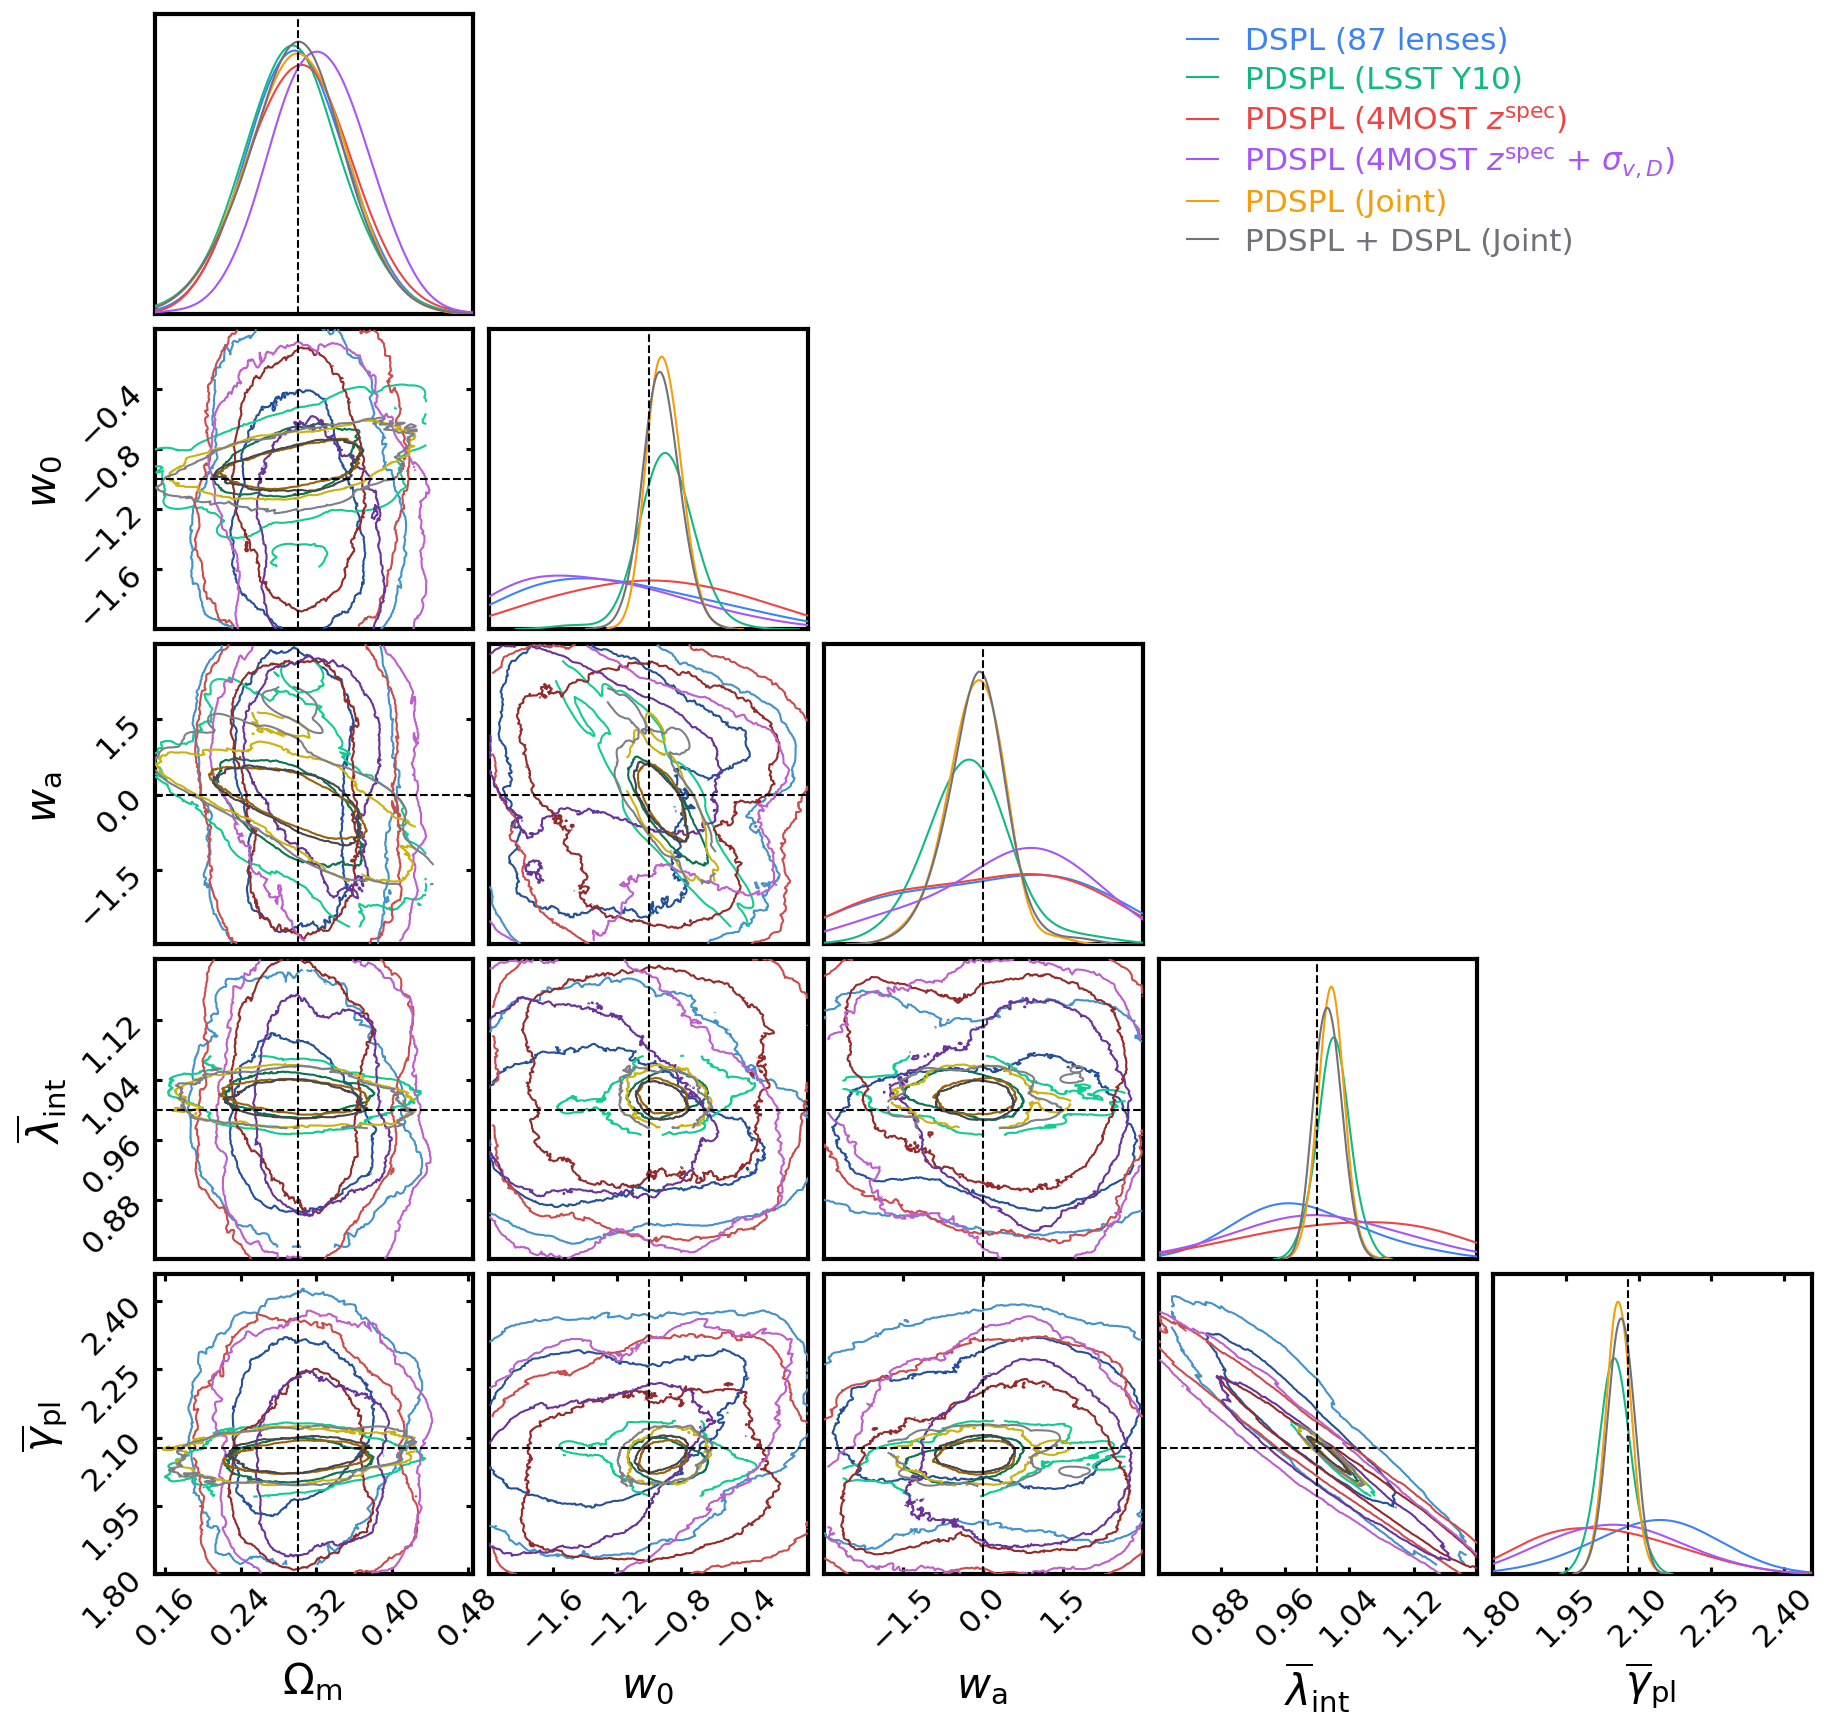

In [21]:
consumer = ChainConsumer()

for key in keys_to_run_forecast:
    chain = forecast_samples[key]['ChainConsumer-Chain']
    consumer.add_chain(chain)

# add truth values
consumer.add_truth(
    Truth(
    location = {
        r"$\Omega_{\rm m}$": om_true,
        r"$w_0$": w0_true,
        r"$w_{\rm a}$": wa_true,
        r"$\overline{\lambda}_{\rm int}$": lambda_mst_mean,
        r"$\overline{\gamma}_{\rm pl}$": gamma_pl_mean,
        # r"$\sigma(\gamma_{\rm pl, global})$": gamma_pl_sigma,
    }
)
)

##### configure plot settings

# extents = {
#                 r"$w_0$": [-2, 0],
#                 r"$w_{\rm a}$": [-3, 3],
#                 r"$\Omega_{\rm m}$": [0.1, 0.5],
#                 r"$\overline{\lambda}_{\rm int}$": [0.8, 1.2],
#                 r"$\overline{\gamma}_{\rm pl}$": [1.5, 2.5],
#                 # r"$\sigma(\gamma_{\rm pl, global})$": [0.0, 0.32],
#             }

consumer.set_plot_config(
        PlotConfig(
            sigmas=[1, 2],
            # extents=extents,
            plot_hists=True,
            legend_kwargs={
                "loc": "upper left",
                "bbox_to_anchor": (-1, 1.),
                "fontsize": 15,
            },
            legend_artists=False,
            tick_font_size=15,
            label_font_size=20,
        )
    )

consumer.set_plot_config(
        PlotConfig(
            sigmas=[1, 2],
            # extents=extents,
            plot_hists=True,
            legend_kwargs={
                "loc": "upper left",
                "bbox_to_anchor": (-1, 1.),
                "fontsize": 15,
            },
            legend_artists=False,
            tick_font_size=15,
            label_font_size=20,
        )
    )

#### Plot and save the forecast results
fig = consumer.plotter.plot(
    columns=[
            '$\\Omega_{\\rm m}$',
            '$w_0$',
            '$w_{\\rm a}$',
            '$\\overline{\\lambda}_{\\rm int}$',
            '$\\overline{\\gamma}_{\\rm pl}$',
            # '$\\sigma(\\gamma_{\\rm pl, global})$'
            ],
    # figsize=(figure_width_inches * 0.8, figure_width_inches * 0.8),
)

# save figure
# fig.savefig(f"../figures/forecast_w0waCDM_om_prior.png", dpi=300, bbox_inches='tight')

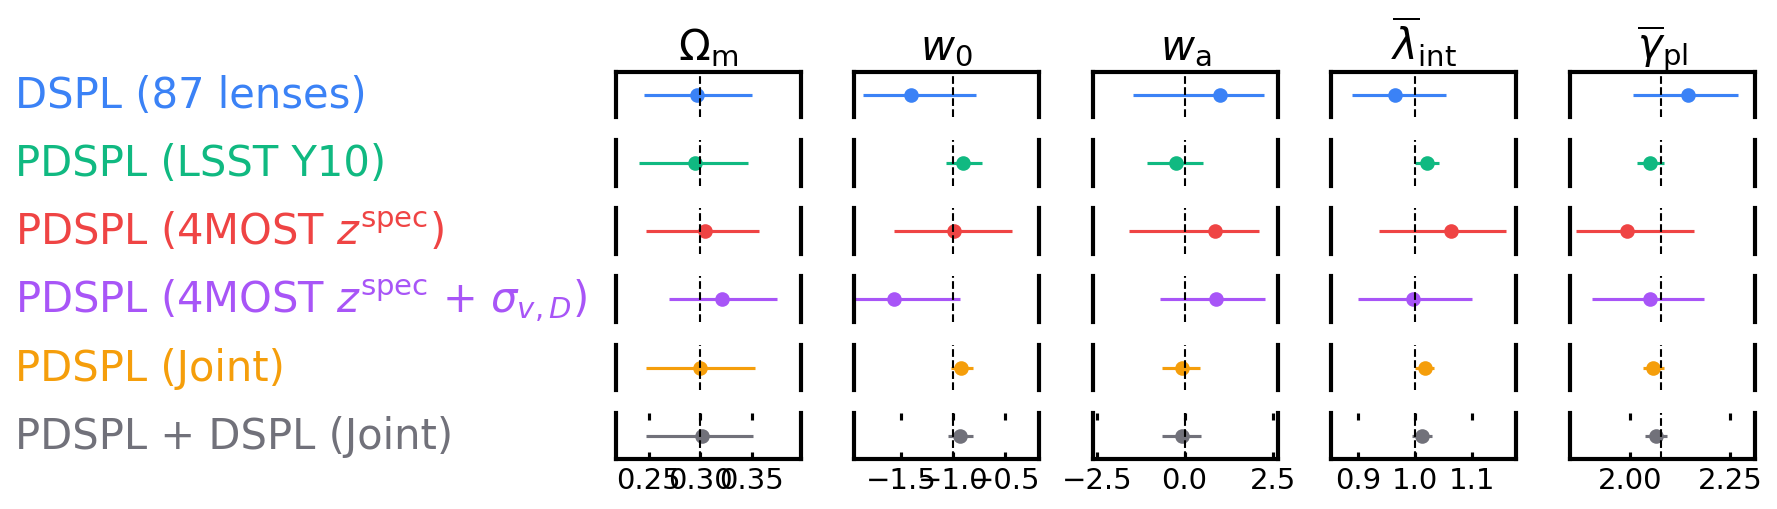

In [22]:
fig = consumer.plotter.plot_summary(errorbar=True);
fig.tight_layout()

In [23]:
latex_table = consumer.analysis.get_latex_table()
print(latex_table)

\begin{table}
    \centering
    \caption{}
    \label{tab:model_params}
    \begin{tabular}{cccccc}
        \hline
		Model & $\Omega_{\rm m}$ & $w_0$ & $w_{\rm a}$ & $\overline{\lambda}_{\rm int}$ & $\overline{\gamma}_{\rm pl}$ \\ 
		\hline
		DSPL (87 lenses) & $0.297^{+0.054}_{-0.051}$ & $-1.40^{+0.63}_{-0.46}$ & $1.0^{+1.3}_{-2.5}$ & $0.964^{+0.089}_{-0.074}$ & $2.14^{+0.13}_{-0.14}$ \\ 
		PDSPL (LSST Y10) & $0.295^{+0.052}_{-0.054}$ & $-0.90^{+0.18}_{-0.17}$ & $-0.26^{+0.76}_{-0.81}$ & $1.020^{+0.021}_{-0.020}$ & $2.049^{+0.034}_{-0.033}$ \\ 
		PDSPL (4MOST $z^{\rm spec}$) & $0.305^{+0.052}_{-0.058}$ & $-0.99^{+0.56}_{-0.58}$ & $0.9^{+1.3}_{-2.4}$ & $1.063^{+0.095}_{-0.126}$ & $1.99^{+0.17}_{-0.13}$ \\ 
		PDSPL (4MOST $z^{\rm spec}$ + $\sigma_{v, D}$) & $0.321^{+0.053}_{-0.051}$ & $-1.56^{+0.63}_{-0.38}$ & $0.9^{+1.4}_{-1.6}$ & $0.996^{+0.104}_{-0.097}$ & $2.05\pm 0.14$ \\ 
		PDSPL (Joint) & $0.300\pm 0.053$ & $-0.92^{+0.12}_{-0.10}$ & $-0.06^{+0.51}_{-0.57}$ & $1.017^{+0.016}_{-0.

## Some Tests

In [24]:
import numpy as np

def check_weighted_sigma(chain):
    om = chain.samples[r"$\Omega_{\rm m}$"]
    weights = chain.samples["weight"]
    
    # Calculate weighted mean
    mean = np.average(om, weights=weights)
    
    # Calculate weighted variance
    variance = np.average((om - mean)**2, weights=weights)
    sigma = np.sqrt(variance)
    
    print(f"Raw weighted sigma: {sigma:.4f}")
    
    # Calculate Effective Sample Size (ESS)
    ess = (np.sum(weights)**2) / np.sum(weights**2)
    print(f"Effective Sample Size: {int(ess)}")

# Run this on your re-weighted chain object
check_weighted_sigma(
    forecast_samples['lsst_y10']['ChainConsumer-Chain']
)

Raw weighted sigma: 0.0475
Effective Sample Size: 600
